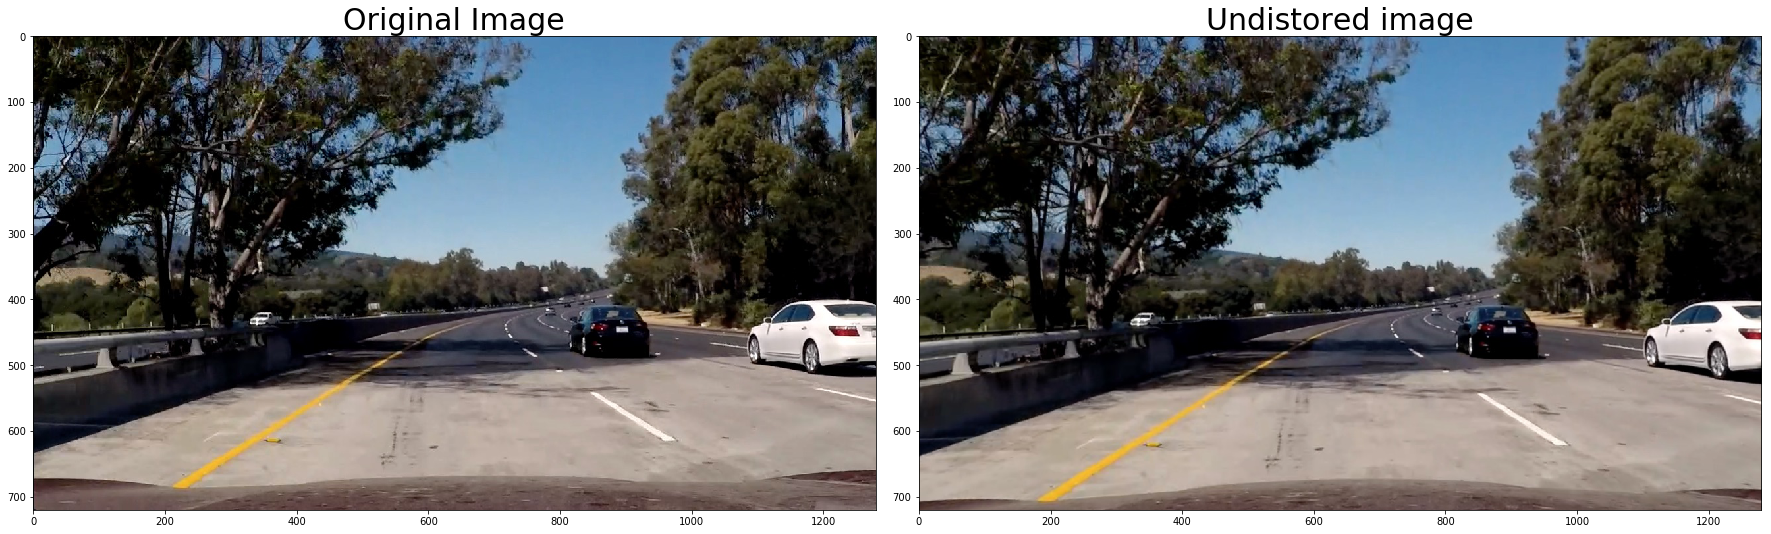

In [277]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "mtx_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

image = mpimg.imread('test_images/test5.jpg')
undist_image = cv2.undistort(image, mtx, dist, None, mtx)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(undist_image)
ax2.set_title('Undistored image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

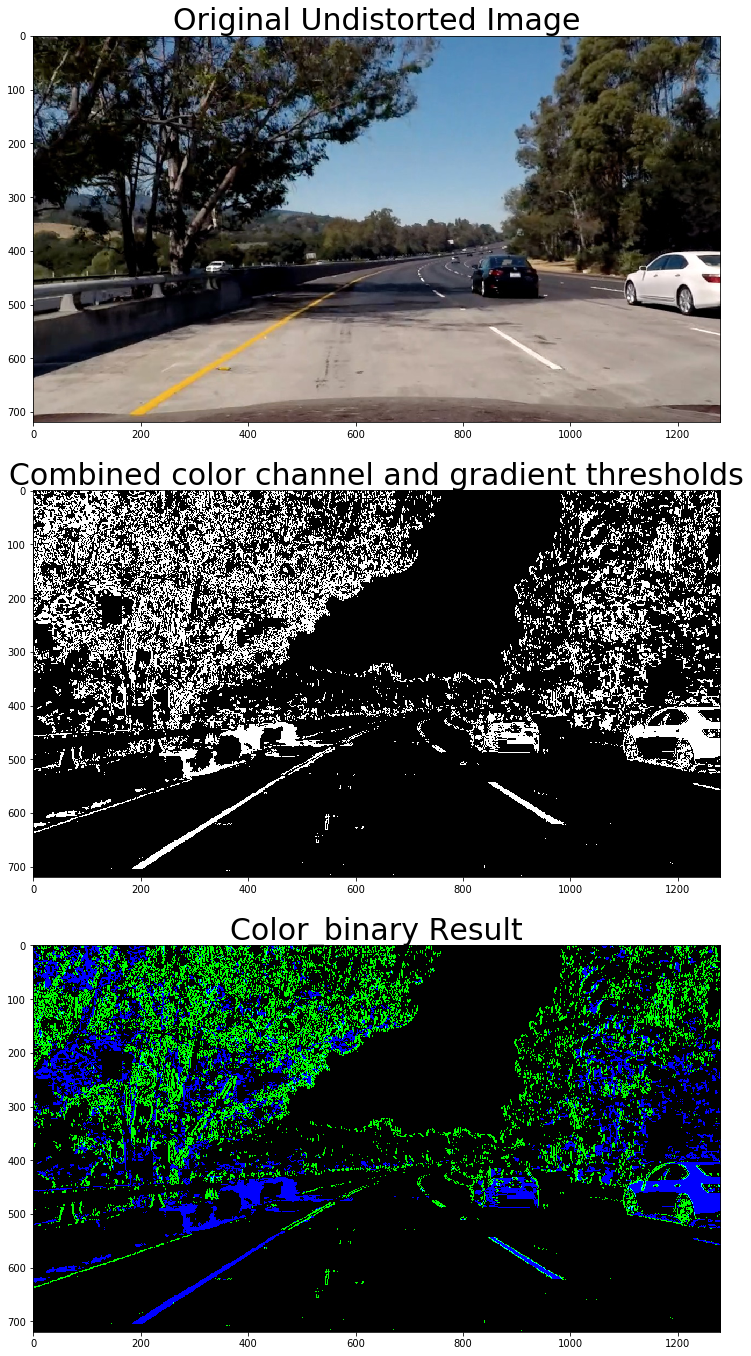

In [291]:

# Process image combining color and gradient threshold
def Color_Gradient(img, s_thresh=(170, 255), l_thresh=(220, 255), b_thresh=(15, 80),
                   h_thresh=(15, 100), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

#     b_channel = img[:,:,2]
    l_channel = luv[:,:,0]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
#     # Sobel y
#     sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
#     abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
#     scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
#     # Threshold x gradient
#     sybinary = np.zeros_like(scaled_sobely)
#     sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    
#     # Threshold color channel b
#     b_binary = np.zeros_like(b_channel)
#     b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1

#     # Threshold color channel H
#     h_binary = np.zeros_like(h_channel)
#     h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    # Threshold color channel S
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold color channel L
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel, Green means the contribution from threshold gradient, Blue is from color threshold
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, l_binary|s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(l_binary == 1) | (s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary
    
color_binary, combined_binary = Color_Gradient(undist_image)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 9))
f.tight_layout()

# ax1.imshow(undist_image)
# ax1.set_title('Original Undistorted Image', fontsize=30)
ax1.imshow(undist_image)
ax1.set_title('Original Undistorted Image', fontsize=30)

src = np.float32([[180,720],[1165,720],[725,470],[560,470]])
ax2.set_title('Combined color channel and gradient thresholds', fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
# ax2.plot([src[i][0] for i in range(len(src))]+[src[0][0]], 
#          [src[i][1] for i in range(len(src))]+[src[0][1]], 'r-')

ax3.imshow(color_binary)
ax3.set_title('Color_binary Result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

f.savefig('output_images/binary_combo_example.jpg', bbox_inches = 'tight')

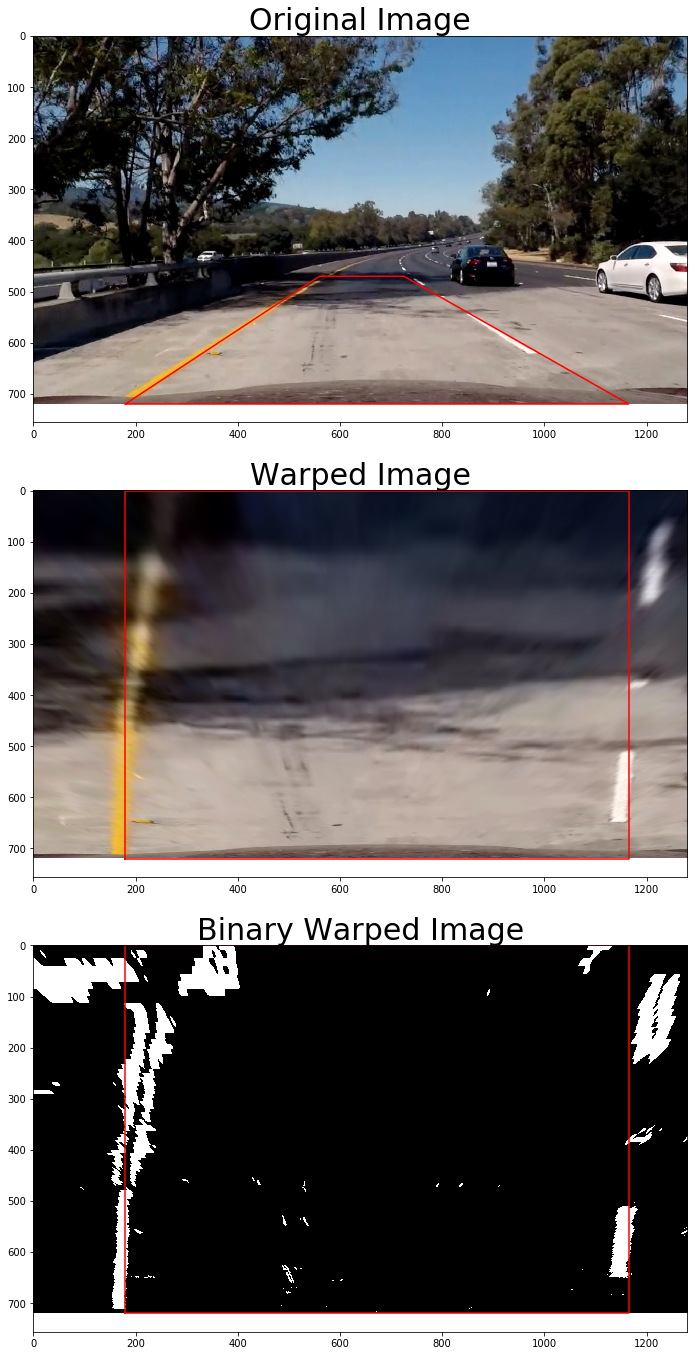

In [279]:
src = np.float32([[180,720],[1165,720],[725,470],[560,470]])
dst = np.float32([[180,720],[1165,720],[1165,0],[180,0]])
def Inverse_Warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    inv_warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return inv_warped

def Perspective_Transform(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

warped = Perspective_Transform(undist_image, src, dst)
binary_warped = Perspective_Transform(combined_binary, src, dst)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_image)
ax1.plot([src[i][0] for i in range(len(src))]+[src[0][0]], 
         [src[i][1] for i in range(len(src))]+[src[0][1]], 'r-')
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)
ax2.plot([dst[i][0] for i in range(len(src))]+[dst[0][0]],
         [dst[i][1] for i in range(len(src))]+[dst[0][1]], 'r-')

ax3.imshow(binary_warped, cmap='gray')
ax3.set_title('Binary Warped Image', fontsize=30)
ax3.plot([dst[i][0] for i in range(len(src))]+[dst[0][0]],
         [dst[i][1] for i in range(len(src))]+[dst[0][1]], 'r-')
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

f.savefig('output_images/warped_straight_lines.jpg', bbox_inches = 'tight')

[  9.8236157    8.00188768   6.21938906   4.47611984   2.77208004
   1.10726963   0.51831137   2.10466296   3.65178515   5.15967794
   6.62834132   8.0577753    9.44797987  10.79895504  12.1107008
  13.38321716  14.61650411  15.81056166  16.9653898   18.08098854]
[False False False False False False False False False False False False
 False False False False False False False False]
Clean!


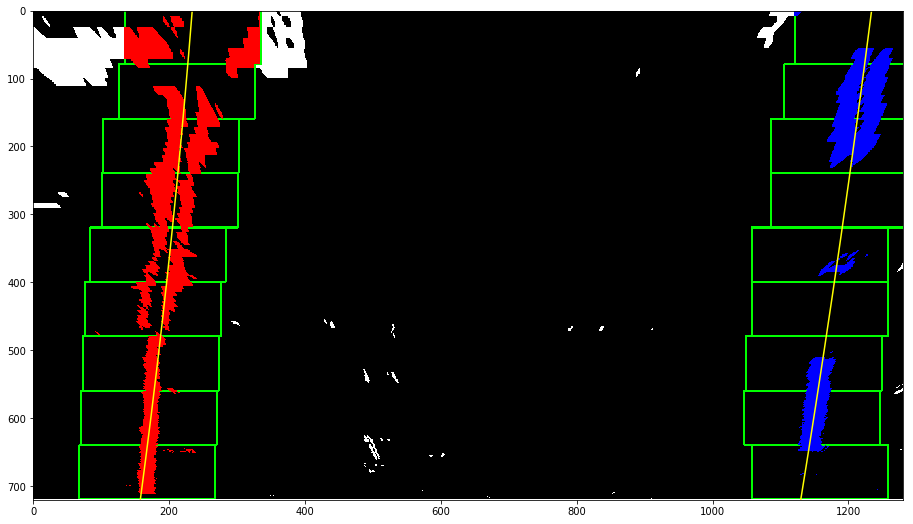

In [280]:
def Sanity_Check(binary_warped, left_fit, right_fit, threshold=130):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    correct_distance = rightx_base - leftx_base
    # Generate x and y values for comparision in both detected lanes
    ploty = np.linspace(0, binary_warped.shape[0], 20 )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    distance = np.absolute(right_fitx - left_fitx)
    difference = np.absolute(distance - correct_distance)
    print (difference)
    print (difference > threshold)
    if np.max(difference > threshold) == True:
        return False
    else:
        return True
    
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
warped_image = out_img

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 100
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
               
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Perform Sanity check to see if the line detected is appropriate based on the distance between those two lines
if Sanity_Check(binary_warped, left_fit, right_fit) == True:
    print ('Clean!')
else:
    print ('Wrong!')
    
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


fig2 = plt.figure(figsize = (24,9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

fig2.savefig('output_images/color_fit_lines.jpg', bbox_inches = 'tight')

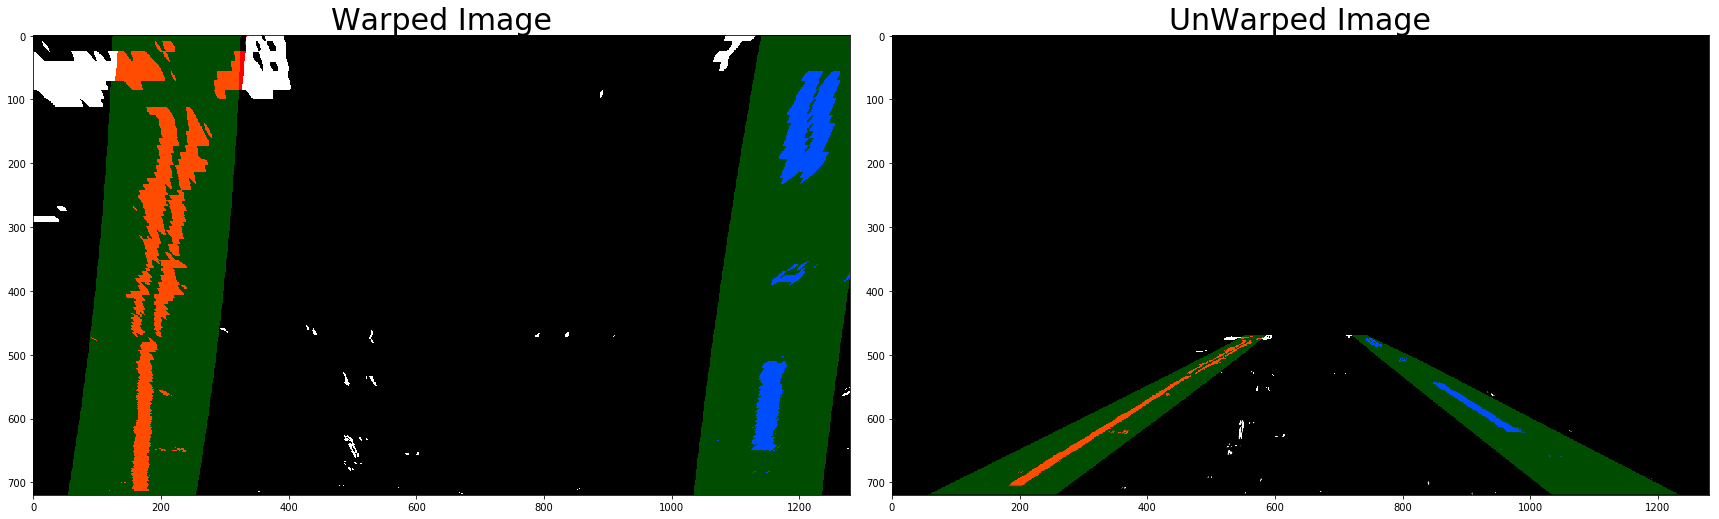

In [281]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#######################################################################
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result)
ax1.set_title('Warped Image', fontsize=30)

ax2.imshow(Inverse_Warp(result, src, dst))
ax2.set_title('UnWarped Image', fontsize=30)

f.savefig('output_images/color_fit_lines2.jpg', bbox_inches = 'tight')
# fig3 = plt.figure(figsize = (24,9))
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

In [288]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 18/720 # meters per pixel in y dimension
xm_per_pix = 3.7/980 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters

ymax = binary_warped.shape[0]
left_ba = left_fit[0]*ymax**2 + left_fit[1]*ymax + left_fit[2]
right_ba = right_fit[0]*ymax**2 + right_fit[1]*ymax + right_fit[2]
midpoint = (right_ba + left_ba)/2
offset = np.absolute((midpoint-binary_warped.shape[1]/2)*xm_per_pix)

print('Vehicle offset from center of lane:' + str(offset)+'m')
print('Estimated radius of left curve: '+str(left_curverad)+'m' '\n'
      'Estimated radius of right curve: '+ str(right_curverad)+ 'm')

Vehicle offset from center of lane:0.019181363642m
Estimated radius of left curve: 890.895991647m
Estimated radius of right curve: 1751.93717719m


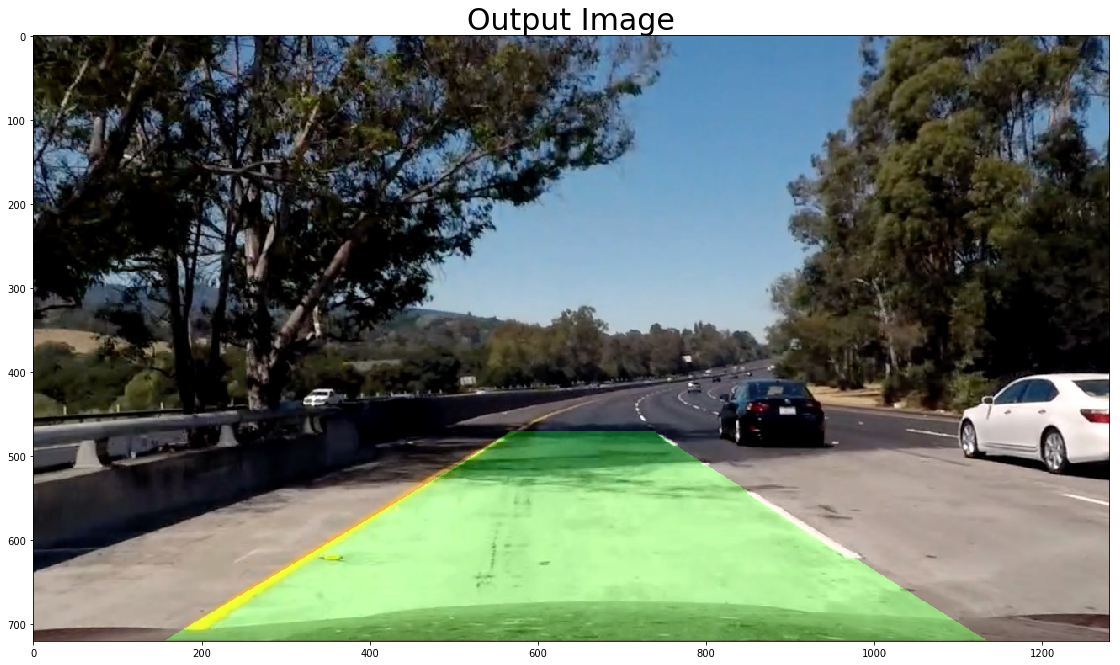

In [289]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = Inverse_Warp(color_warp, src, dst) 
# Combine the result with the original image
result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)

f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result)
ax1.set_title('Output Image', fontsize=30)

# ax2.imshow(newwarp)
# ax2.set_title('Color Warped Image', fontsize=30)

f.savefig('output_images/example_output.jpg', bbox_inches = 'tight')

[(122.0, 1062.0), (126.0, 1062.0), (137.0, 1053.0), (139.0, 1053.0), (157.0, 1049.0), (172.0, 1049.0), (189.0, 1041.0), (204.0, 1040.0), (204.0, 1043.0)]


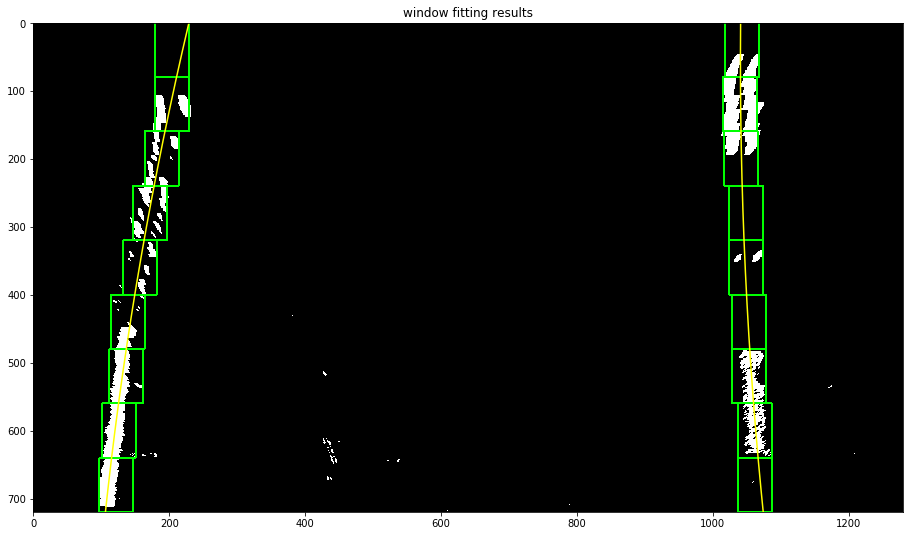

In [209]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

image = mpimg.imread('test_images/test5.jpg')
undist_image = cv2.undistort(image, mtx, dist, None, mtx)
color_binary, combined_binary = Color_Gradient(undist_image)
binary_warped = Perspective_Transform(combined_binary, src, dst)

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(1*image.shape[0]/2):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(1*image.shape[0]/2):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
    
        if np.absolute(l_center-window_centroids[level-1][0]) > (window_width) :
            l_center = window_centroids[level-1][0]
        if np.absolute(r_center-window_centroids[level-1][1]) > (window_width) :
            r_center = window_centroids[level-1][1] 
            
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)
print (window_centroids)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#Find the nonzero pixel in each window
for window in range(len(window_centroids)):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = max(0,int(window_centroids[window][0]-window_width/2))
    win_xleft_high = min(int(window_centroids[window][0]+window_width/2),binary_warped.shape[1])
    win_xright_low = max(0,int(window_centroids[window][1]-window_width/2))
    win_xright_high = min(int(window_centroids[window][1]+window_width/2),binary_warped.shape[1])
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(int(win_xleft_low),win_y_low),(int(win_xleft_high),win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(int(win_xright_low),win_y_low),(int(win_xright_high),win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
   
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# ###
# leftx = [window_centroids[i][0] for i in range(len(window_centroids))]
# rightx = [window_centroids[i][1] for i in range((int)(len(window_centroids)))]
# lefty = [warped.shape[0]-window_height*level for level in range((int)(binary_warped.shape[0]/window_height))]
# righty = lefty

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
       
# Display the final results
fig3 = plt.figure(figsize = (24,9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title('window fitting results')
plt.show()

Text(0.5,1,'Color Warped Image')

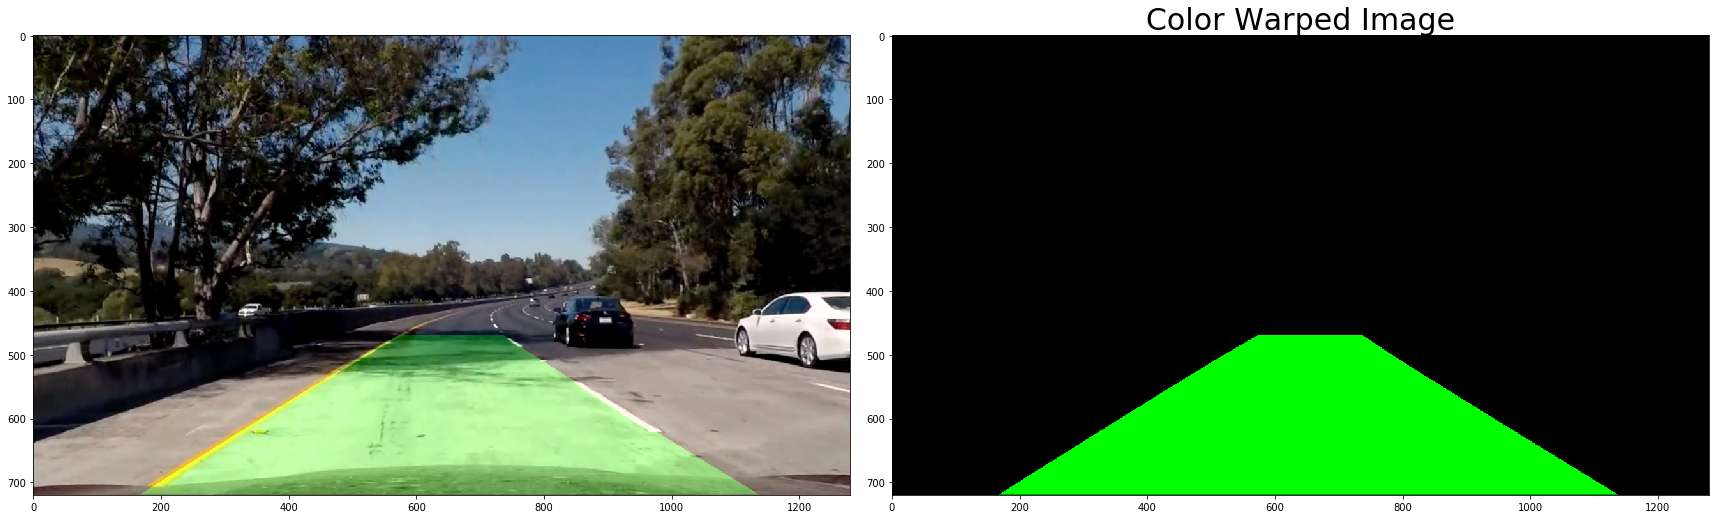

In [210]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = Inverse_Warp(color_warp, src, dst) 
# Combine the result with the original image
result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result)

ax2.imshow(newwarp)
ax2.set_title('Color Warped Image', fontsize=30)

